In [1]:
import cv2
import mediapipe as mp
import numpy as np
import math
import csv
import time
import os
import warnings
import glob
from tqdm.notebook import tqdm # Thanh tiến trình
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import google.protobuf

warnings.filterwarnings('ignore')

In [2]:
# Khởi tạo giải pháp MediaPipe
mp_pose = mp.solutions.pose

def calculate_angle(a, b, c):
    """(Đã sửa) Tính góc (0-180 độ) với b là đỉnh."""
    try:
        ang_rad = math.atan2(c['py'] - b['py'], c['px'] - b['px']) - \
                  math.atan2(a['py'] - b['py'], a['px'] - b['px'])
        ang_deg = math.degrees(ang_rad)
        ang_deg = ang_deg % 360
        if ang_deg > 180:
            ang_deg = 360 - ang_deg
        return abs(ang_deg)
    except:
        return 0

def calculate_distance(a, b):
    """Tính khoảng cách Euclidean 2D giữa 2 điểm."""
    try:
        return math.sqrt((a['px'] - b['px'])**2 + (a['py'] - b['py'])**2)
    except:
        return 0

def get_view(landmarks):
    """Xác định góc nhìn của camera dựa trên tọa độ Z của vai."""
    try:
        l_shoulder = landmarks[mp_pose.PoseLandmark.LEFT_SHOULDER.value]
        r_shoulder = landmarks[mp_pose.PoseLandmark.RIGHT_SHOULDER.value]
    except:
        return "Unknown"

    l_vis, r_vis = l_shoulder['vis'], r_shoulder['vis']
    l_z, r_z = l_shoulder['z'], r_shoulder['z']
    vis_thresh = 0.7
    z_diff = l_z - r_z
    front_thresh = 0.08
    diag_thresh = 0.25
    view = "Unknown"

    if l_vis > vis_thresh and r_vis > vis_thresh:
        if abs(z_diff) < front_thresh:
            view = "Front"
        elif z_diff > diag_thresh:
            view = "Left"
        elif z_diff < -diag_thresh:
            view = "Right"
        elif z_diff > front_thresh:
            view = "Diagonal Left"
        elif z_diff < -front_thresh:
            view = "Diagonal Right"
    elif l_vis > vis_thresh:
        view = "Right"
    elif r_vis > vis_thresh:
        view = "Left"
        
    return view

In [3]:
def analyze_video_frames(pose_detector, video_path, csv_writer, video_id):
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        return []

    TARGET_WIDTH = 1200
    
    # --- CÁC BIẾN TRẠNG THÁI ---
    frame_id = 0
    rep_id_counter = 0
    state = "down" # Bicep curl bắt đầu ở tư thế tay duỗi (down)
    view = "Initializing"
    
    # --- NGƯỠNG (THRESHOLDS) CHO BICEP CURL ---
    # Lưu ý: Góc khuỷu tay (Vai-Khuỷu-Cổ tay)
    # Duỗi thẳng = 180 độ (State Down)
    # Gập hết cỡ = ~30 độ (State Up)
    UP_THRESHOLD = 40   # Góc nhỏ hơn mức này => Đang gập (UP)
    DOWN_THRESHOLD = 160 # Góc lớn hơn mức này => Đang duỗi (DOWN)
    
    # --- BIẾN LOGIC REP ---
    current_rep_frames = 0
    rep_state = "N/A" 
    
    # rep_data_log sẽ chứa cả Landmarks VÀ Labels của frame đó
    rep_data_log = [] 

    # Biến heuristic cho Rep Summary
    completed_rep_stats = [] 

    while cap.isOpened():
        success, image = cap.read()
        if not success: break
        frame_id += 1

        # --- Xử lý hình ảnh ---
        h, w = image.shape[:2]
        scale = TARGET_WIDTH / w
        dim = (TARGET_WIDTH, int(h * scale))
        image_resized = cv2.resize(image, dim, interpolation=cv2.INTER_AREA)
        h, w = image_resized.shape[:2]
        image_rgb = cv2.cvtColor(image_resized, cv2.COLOR_BGR2RGB)
        results = pose_detector.process(image_rgb)

        # --- Khởi tạo biến lỗi cho Frame hiện tại (BICEP CURL SPECIFIC) ---
        # label_back: Lỗi dùng đà lưng
        # label_elbow: Lỗi trượt khuỷu tay (Elbow Drift)
        # label_flare: Lỗi mở rộng khuỷu tay sang hai bên (Flaring)
        frame_errors = {"back": 0, "elbow": 0, "flare": 0}
        
        lm_coords = {}
        lm_data_row_base = [frame_id]
        avg_elbow_angle = 0 

        if results.pose_landmarks:
            landmarks_raw = results.pose_landmarks.landmark
            for id, lm in enumerate(landmarks_raw):
                cx, cy = int(lm.x * w), int(lm.y * h)
                lm_coords[id] = {'x': lm.x, 'y': lm.y, 'z': lm.z, 'vis': lm.visibility, 'px': cx, 'py': cy}
                lm_data_row_base.extend([lm.x, lm.y, lm.z, lm.visibility])
            
            view = get_view(lm_coords) 
            
            # === TÍNH TOÁN GÓC KHUỶU TAY (ELBOW ANGLE) ===
            # Tính góc tạo bởi: Vai (11/12) - Khuỷu (13/14) - Cổ tay (15/16)
            try:
                # Left Arm: 11-13-15
                la = calculate_angle(lm_coords[11], lm_coords[13], lm_coords[15])
                # Right Arm: 12-14-16
                ra = calculate_angle(lm_coords[12], lm_coords[14], lm_coords[16])
                
                avg_elbow_angle = (la + ra) / 2
            except: 
                avg_elbow_angle = 180 # Mặc định là duỗi nếu lỗi

            # === LOGIC HEURISTIC (CHECK LỖI TỪNG FRAME CHO BICEP CURL) ===
            
            # 1. Lỗi Body Swing (Dùng đà lưng) - Chỉ check ở góc nghiêng
            if view != "Front" and view != "Unknown":
                try:
                    # Chọn bên đang nhìn thấy rõ nhất
                    side_idx, ear_idx, shoulder_idx, hip_idx = (23, 7, 11, 23) if "Left" in view else (24, 8, 12, 24)
                    # Góc lưng: Tai - Vai - Hông (Hoặc dùng phương thẳng đứng)
                    # Ở đây dùng logic cũ: check độ ngả
                    # Một cách chính xác hơn cho swing: so sánh Vai với Hông theo trục X
                    
                    # Cách 1: Góc Hip-Shoulder-Ear (như cũ)
                    torso_angle = calculate_angle(lm_coords[ear_idx], lm_coords[shoulder_idx], lm_coords[hip_idx])
                    # Bình thường thẳng đứng là 180. Nếu ngả ra sau < 170 hoặc > 190 (tùy cách tính góc)
                    if torso_angle < 165: frame_errors["back"] = 1
                except: pass
            
            # 2. Lỗi Elbow Drift (Trượt khuỷu tay) - Quan trọng ở góc nghiêng
            # Khuỷu tay phải cố định bên cạnh sườn, không được di chuyển xa so với trục cơ thể
            if view != "Front" and view != "Unknown":
                try:
                    shoulder_idx = 11 if "Left" in view else 12
                    elbow_idx = 13 if "Left" in view else 14
                    
                    # Kiểm tra khoảng cách theo trục X giữa Vai và Khuỷu tay
                    # Trong Bicep Curl chuẩn, khuỷu tay nằm ngay dưới vai hoặc hơi nhích nhẹ
                    # Nếu diff_x lớn nghĩa là khuỷu bị trượt ra trước hoặc sau
                    diff_x = abs(lm_coords[shoulder_idx]['x'] - lm_coords[elbow_idx]['x'])
                    
                    # Ngưỡng heuristic (cần tinh chỉnh tùy dataset), ví dụ 0.1 (10% khung hình)
                    if diff_x > 0.12: 
                        frame_errors["elbow"] = 1
                except: pass

            # 3. Lỗi Flaring (Khuỷu tay mở rộng) - Quan trọng ở góc Front
            # Khi nhìn thẳng, khuỷu tay không được bành ra quá xa so với vai
            if view == "Front":
                try:
                    # Tính khoảng cách ngang giữa Vai và Khuỷu tay
                    l_flare = abs(lm_coords[11]['x'] - lm_coords[13]['x'])
                    r_flare = abs(lm_coords[12]['x'] - lm_coords[14]['x'])
                    
                    # Nếu khuỷu tay bành ra, x sẽ lệch xa so với vai
                    if l_flare > 0.15 or r_flare > 0.15: # Ngưỡng heuristic
                        frame_errors["flare"] = 1
                except: pass
            
            # Nếu view nghiêng nhưng tay vẫn bành ra (kiểm tra Z nếu có depth tốt, hoặc bỏ qua)
            # Tạm thời chỉ check Flare ở Front view cho chính xác

            # === STATE MACHINE (BICEP CURL LOGIC) ===
            # Logic ngược với Lateral Raise:
            # - Góc nhỏ (< UP_THRESHOLD) là UP (Gập)
            # - Góc lớn (> DOWN_THRESHOLD) là DOWN (Duỗi)
            
            if avg_elbow_angle < UP_THRESHOLD: # Đang gập tay (Top position)
                state = "up"
                if rep_state != "In Progress":
                    rep_state = "In Progress"
                    rep_data_log = [] # Reset log cho rep mới
                    current_rep_frames = 0
            
            elif avg_elbow_angle > DOWN_THRESHOLD: # Đang duỗi tay (Bottom position)
                prev_state = state
                state = "down"
                
                # KẾT THÚC REP (Chuyển từ Up -> Down)
                if prev_state == "up" and rep_state == "In Progress":
                    rep_id_counter += 1
                    
                    # Lọc nhiễu: Chỉ ghi nếu rep đủ dài
                    if current_rep_frames > 5: 
                        # --- WRITE LOGIC ---
                        # Tính toán xem lỗi nào chiếm đa số trong Rep này?
                        # Ở đây logic là: Ghi từng frame, nhưng ta có thể hậu xử lý gán nhãn cả rep
                        
                        # Logic yêu cầu: Nếu > 20% frame trong rep bị lỗi -> Gán lỗi cho cả rep (tất cả frame)
                        temp_df = pd.DataFrame([x[-3:] for x in rep_data_log], columns=["back", "elbow", "flare"])
                        
                        final_rep_labels = [0, 0, 0]
                        if (temp_df["back"].sum() / len(temp_df)) > 0.3: final_rep_labels[0] = 1
                        if (temp_df["elbow"].sum() / len(temp_df)) > 0.3: final_rep_labels[1] = 1
                        if (temp_df["flare"].sum() / len(temp_df)) > 0.3: final_rep_labels[2] = 1
                        
                        # Ghi vào CSV
                        for i, frame_packet in enumerate(rep_data_log):
                            # frame_packet cấu trúc cũ: [...landmarks..., err_back, err_elbow, err_flare]
                            # Thay thế 3 phần tử cuối bằng nhãn thống nhất của Rep (Majority vote logic)
                            # Hoặc giữ nguyên frame-based label nếu muốn real-time (Ở đây dùng Rep-based label cho sạch data training)
                            
                            data_without_label = frame_packet[:-3]
                            row = [video_id, rep_id_counter] + data_without_label + final_rep_labels
                            csv_writer.writerow(row)
                        
                        completed_rep_stats.append({
                            "rep_id": rep_id_counter,
                            "frames": current_rep_frames,
                            "errors": final_rep_labels
                        })
                    
                    # Reset trạng thái
                    rep_state = "Done"
                    rep_data_log = []

            # === DATA COLLECTION ===
            if rep_state == "In Progress":
                current_rep_frames += 1
                
                # Lưu labels thô của frame hiện tại
                current_labels = [frame_errors["back"], frame_errors["elbow"], frame_errors["flare"]]
                
                # Nối landmarks + labels
                full_frame_data = lm_data_row_base + current_labels
                rep_data_log.append(full_frame_data)
            
    cap.release()
    return completed_rep_stats

In [7]:
def analyze_video_frames(pose_detector, video_path, csv_writer, video_id):
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        return []

    TARGET_WIDTH = 1200
    
    # --- CÁC BIẾN TRẠNG THÁI ---
    frame_id = 0
    rep_id_counter = 0
    state = "down" 
    view = "Initializing"
    
    # --- [ĐIỀU CHỈNH QUAN TRỌNG] THRESHOLDS ---
    # Relaxed Thresholds: Tăng độ nhạy để bắt được nhiều Rep hơn
    # UP: Tăng lên 75 (Thay vì 40) -> Dễ đạt trạng thái "Gập" hơn
    # DOWN: Giảm xuống 145 (Thay vì 160) -> Dễ đạt trạng thái "Duỗi" hơn
    UP_THRESHOLD = 75   
    DOWN_THRESHOLD = 145 
    
    # --- BIẾN LOGIC REP ---
    current_rep_frames = 0
    rep_state = "N/A" 
    rep_data_log = [] 
    completed_rep_stats = [] 

    while cap.isOpened():
        success, image = cap.read()
        if not success: break
        frame_id += 1

        # --- Xử lý hình ảnh ---
        h, w = image.shape[:2]
        # Resize để tăng tốc độ xử lý
        scale = TARGET_WIDTH / w
        dim = (TARGET_WIDTH, int(h * scale))
        image_resized = cv2.resize(image, dim, interpolation=cv2.INTER_AREA)
        h, w = image_resized.shape[:2]
        image_rgb = cv2.cvtColor(image_resized, cv2.COLOR_BGR2RGB)
        
        # Detect
        results = pose_detector.process(image_rgb)

        # Init labels
        frame_errors = {"back": 0, "elbow": 0, "flare": 0}
        lm_coords = {}
        lm_data_row_base = [frame_id]
        avg_elbow_angle = 180 # Mặc định là duỗi

        if results.pose_landmarks:
            landmarks_raw = results.pose_landmarks.landmark
            for id, lm in enumerate(landmarks_raw):
                cx, cy = int(lm.x * w), int(lm.y * h)
                lm_coords[id] = {'x': lm.x, 'y': lm.y, 'z': lm.z, 'vis': lm.visibility, 'px': cx, 'py': cy}
                lm_data_row_base.extend([lm.x, lm.y, lm.z, lm.visibility])
            
            view = get_view(lm_coords) 
            
            # === TÍNH TOÁN GÓC KHUỶU TAY ===
            try:
                # Left Arm: 11-13-15
                la = calculate_angle(lm_coords[11], lm_coords[13], lm_coords[15])
                # Right Arm: 12-14-16
                ra = calculate_angle(lm_coords[12], lm_coords[14], lm_coords[16])
                
                # Lấy trung bình hoặc lấy bên có độ tin cậy cao hơn
                # Ở đây lấy trung bình để đơn giản
                avg_elbow_angle = (la + ra) / 2
            except: 
                avg_elbow_angle = 180 

            # [DEBUG OPTION] Bỏ comment dòng dưới để xem góc thực tế máy đo được là bao nhiêu
            # if frame_id % 10 == 0: print(f"Video: {video_id} | Angle: {avg_elbow_angle:.1f} | State: {state}")

            # === LOGIC HEURISTIC CHECK LỖI ===
            if view != "Front" and view != "Unknown":
                try:
                    # 1. Body Swing (Lưng)
                    side_idx, ear_idx, shoulder_idx, hip_idx = (23, 7, 11, 23) if "Left" in view else (24, 8, 12, 24)
                    torso_angle = calculate_angle(lm_coords[ear_idx], lm_coords[shoulder_idx], lm_coords[hip_idx])
                    if torso_angle < 165: frame_errors["back"] = 1
                    
                    # 2. Elbow Drift (Trượt khuỷu)
                    shoulder_idx = 11 if "Left" in view else 12
                    elbow_idx = 13 if "Left" in view else 14
                    diff_x = abs(lm_coords[shoulder_idx]['x'] - lm_coords[elbow_idx]['x'])
                    if diff_x > 0.12: frame_errors["elbow"] = 1
                except: pass

            if view == "Front":
                try:
                    # 3. Flaring (Bành tay)
                    l_flare = abs(lm_coords[11]['x'] - lm_coords[13]['x'])
                    r_flare = abs(lm_coords[12]['x'] - lm_coords[14]['x'])
                    if l_flare > 0.15 or r_flare > 0.15: frame_errors["flare"] = 1
                except: pass

            # === STATE MACHINE (RELAXED) ===
            
            # Điều kiện UP (Gập tay): Góc nhỏ hơn 75 độ (dễ đạt được hơn 40)
            if avg_elbow_angle < UP_THRESHOLD: 
                state = "up"
                if rep_state != "In Progress":
                    rep_state = "In Progress"
                    rep_data_log = []
                    current_rep_frames = 0
            
            # Điều kiện DOWN (Duỗi tay): Góc lớn hơn 145 độ (dễ đạt được hơn 160)
            elif avg_elbow_angle > DOWN_THRESHOLD: 
                prev_state = state
                state = "down"
                
                # KẾT THÚC REP
                if prev_state == "up" and rep_state == "In Progress":
                    rep_id_counter += 1
                    
                    # Giữ nguyên filter nhiễu > 5 frame
                    if current_rep_frames > 5: 
                        # Tính toán Majority Vote cho Rep Label
                        temp_df = pd.DataFrame([x[-3:] for x in rep_data_log], columns=["back", "elbow", "flare"])
                        final_rep_labels = [0, 0, 0]
                        
                        # Nếu > 25% số frame lỗi thì gán lỗi cho cả rep (hạ ngưỡng vote xuống xíu)
                        if len(temp_df) > 0:
                            if (temp_df["back"].sum() / len(temp_df)) > 0.25: final_rep_labels[0] = 1
                            if (temp_df["elbow"].sum() / len(temp_df)) > 0.25: final_rep_labels[1] = 1
                            if (temp_df["flare"].sum() / len(temp_df)) > 0.25: final_rep_labels[2] = 1
                        
                        # Ghi vào CSV
                        for frame_packet in rep_data_log:
                            data_without_label = frame_packet[:-3]
                            row = [video_id, rep_id_counter] + data_without_label + final_rep_labels
                            csv_writer.writerow(row)
                        
                        completed_rep_stats.append({
                            "rep_id": rep_id_counter,
                            "frames": current_rep_frames
                        })
                    
                    rep_state = "Done"
                    rep_data_log = []

            # === DATA COLLECTION ===
            # Thu thập dữ liệu ngay khi đang trong trạng thái thực hiện động tác
            if rep_state == "In Progress":
                current_rep_frames += 1
                current_labels = [frame_errors["back"], frame_errors["elbow"], frame_errors["flare"]]
                full_frame_data = lm_data_row_base + current_labels
                rep_data_log.append(full_frame_data)
            
    cap.release()
    return completed_rep_stats

In [8]:
# === 1. ĐỊNH NGHĨA ĐƯỜNG DẪN ===
VIDEO_FOLDER = '../data/biceps curl' 
OUTPUT_DIR = 'output'
# Lưu ý: Giữ đúng chính tả "summarry" theo yêu cầu
SUMMARY_CSV_NAME = 'summarry_biceps_curl.csv' 
SUMMARY_CSV_PATH = os.path.join(OUTPUT_DIR, SUMMARY_CSV_NAME)

# === 2. TẠO THƯ MỤC OUTPUT ===
os.makedirs(OUTPUT_DIR, exist_ok=True)
print(f"Đã tạo/xác nhận thư mục output tại: {os.path.abspath(OUTPUT_DIR)}")

# === 3. TÌM TẤT CẢ VIDEO ===
video_extensions = ["*.mp4", "*.avi", "*.mov", "*.mkv"]
video_files = []
for ext in video_extensions:
    video_files.extend(glob.glob(os.path.join(VIDEO_FOLDER, ext)))
print(f"Tìm thấy tổng cộng {len(video_files)} video.")

# === 4. KHỞI TẠO MEDIAPIPE (1 LẦN) ===
pose_detector = mp_pose.Pose(min_detection_confidence=0.5, 
                             min_tracking_confidence=0.5,
                             model_complexity=1)

# === 5. XỬ LÝ HÀNG LOẠT (GHI VÀO 1 FILE) ===

# Tạo header cho file CSV tổng
landmarks_header = []
for i in range(33):
    landmarks_header.extend([f'lm_{i}_x', f'lm_{i}_y', f'lm_{i}_z', f'lm_{i}_vis'])

# THAY ĐỔI: Cập nhật các cột nhãn mới cho Bicep Curl
label_headers = ['label_back', 'label_elbow', 'label_flare']

csv_header = ['video_id', 'rep_id', 'frame_id'] + landmarks_header + label_headers

# List để lưu thống kê (không ghi vào file, chỉ để print log nếu cần)
all_rep_stats = []

if not video_files:
    print(f"CẢNH BÁO: Không tìm thấy video nào trong '{VIDEO_FOLDER}'.")
else:
    # Mở file CSV TỔNG HỢP (chỉ 1 lần)
    with open(SUMMARY_CSV_PATH, 'w', newline='', encoding='utf-8') as csv_file:
        csv_writer = csv.writer(csv_file)
        csv_writer.writerow(csv_header) # Viết header 1 lần duy nhất
        
        print(f"Đang ghi vào file summary: {SUMMARY_CSV_PATH}")
        
        # Dùng tqdm để tạo thanh tiến trình
        for video_path in tqdm(video_files, desc="Đang xử lý các video"):
            
            # Dùng tên file (không có đuôi) làm video_id
            video_id = os.path.splitext(os.path.basename(video_path))[0]
            
            # Gọi hàm xử lý, truyền csv_writer và video_id
            stats = analyze_video_frames(
                pose_detector, video_path, csv_writer, video_id
            )
            all_rep_stats.extend(stats)

# === 6. DỌN DẸP MODEL ===
pose_detector.close()
print(f"\n--- Xử lý hàng loạt hoàn tất! ---")
print(f"Tổng số {len(all_rep_stats)} rep đã được xử lý và ghi vào file summary.")

Đã tạo/xác nhận thư mục output tại: e:\Learning\Collage\2026\hocki1\PBL 6\notebooks\output
Tìm thấy tổng cộng 63 video.
Đang ghi vào file summary: output\summarry_biceps_curl.csv


Đang xử lý các video:   0%|          | 0/63 [00:00<?, ?it/s]


--- Xử lý hàng loạt hoàn tất! ---
Tổng số 83 rep đã được xử lý và ghi vào file summary.


Đọc file summary từ: output/summarry_biceps_curl.csv

--- THỐNG KÊ TRÊN TỔNG SỐ 3135 FRAMES ---
label_back     1434
label_elbow      49
label_flare       6
dtype: int64

Số frame 'Correct' (Không lỗi): 1695


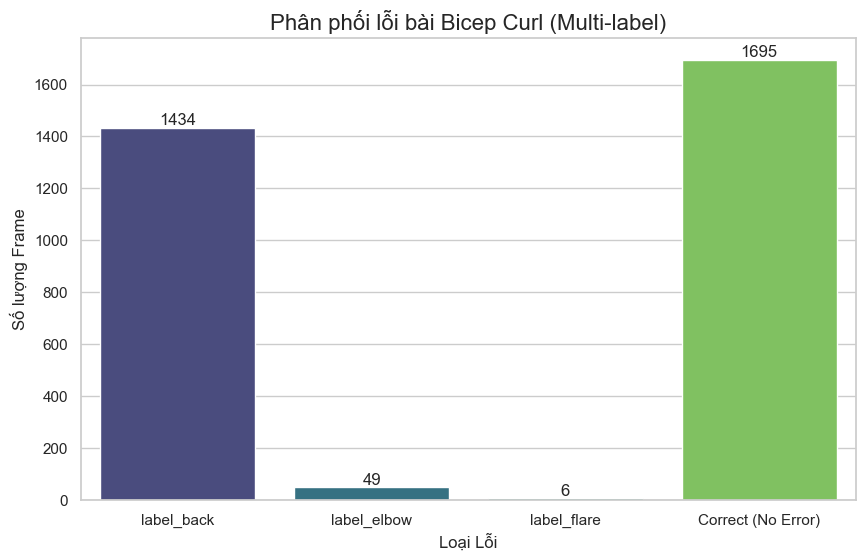


5 Dòng dữ liệu mẫu (Labels):
      label_back  label_elbow  label_flare
1417           1            0            0
157            1            0            0
2890           1            0            0
1569           0            0            0
1030           1            1            0


In [9]:
# Đường dẫn file (Đảm bảo giống cell trên)
SUMMARY_CSV_PATH = 'output/summarry_biceps_curl.csv'

print(f"Đọc file summary từ: {SUMMARY_CSV_PATH}")

try:
    df = pd.read_csv(SUMMARY_CSV_PATH)

    if df.empty:
        print("File summary rỗng. Hãy kiểm tra lại bước xử lý video.")
    else:
        # Danh sách các cột nhãn mới cho Bicep Curl
        label_cols = ['label_back', 'label_elbow', 'label_flare']
        
        # Kiểm tra xem file CSV có đúng định dạng mới không
        if not all(col in df.columns for col in label_cols):
            print(f"LỖI: File CSV chưa có các cột nhãn: {label_cols}")
            print("Các cột hiện có:", df.columns.tolist())
        else:
            total_frames = len(df)
            print(f"\n--- THỐNG KÊ TRÊN TỔNG SỐ {total_frames} FRAMES ---")
            
            # 1. Đếm số lượng frame bị lỗi cho từng loại
            error_counts = df[label_cols].sum().sort_values(ascending=False)
            print(error_counts)
            
            # 2. Đếm số frame "Sạch" (Correct - không dính lỗi nào)
            correct_frames = df[df[label_cols].sum(axis=1) == 0].shape[0]
            print(f"\nSố frame 'Correct' (Không lỗi): {correct_frames}")
            
            # === VẼ BIỂU ĐỒ ===
            plt.figure(figsize=(10, 6))
            
            # Tạo dữ liệu để vẽ
            plot_data = error_counts.to_frame(name='Count').reset_index()
            plot_data.columns = ['Error Type', 'Count']
            
            # Thêm cột Correct vào biểu đồ để so sánh
            new_row = pd.DataFrame({'Error Type': ['Correct (No Error)'], 'Count': [correct_frames]})
            plot_data = pd.concat([plot_data, new_row], ignore_index=True)
            
            # Vẽ Bar Chart
            sns.set_theme(style="whitegrid")
            ax = sns.barplot(x='Error Type', y='Count', data=plot_data, palette='viridis')
            
            ax.set_title('Phân phối lỗi bài Bicep Curl (Multi-label)', fontsize=16)
            ax.set_ylabel('Số lượng Frame', fontsize=12)
            ax.set_xlabel('Loại Lỗi', fontsize=12)
            
            # Hiển thị số liệu trên đầu cột
            for i in ax.containers:
                ax.bar_label(i,)
                
            plt.show()

            # === KIỂM TRA MẪU DỮ LIỆU ===
            print("\n5 Dòng dữ liệu mẫu (Labels):")
            print(df[label_cols].sample(5))

except FileNotFoundError:
    print(f"Không tìm thấy file: {SUMMARY_CSV_PATH}")
except Exception as e:
    print(f"Lỗi không mong muốn: {e}")